In [161]:
from pymystem3 import Mystem
from nltk.corpus import stopwords
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso
import numpy as np

In [169]:

russian_stopwords = stopwords.words("russian")
m = Mystem()

In [134]:
special = ['beg', 'haps', 'sads', 'excl', 'point', 'myst', 'en', 'не']

def word_map_punct(word):
    happy_smiles = [':)', ';)', ':-)', ':D', ':P', ';-)', '(:', '(-:', '((']
    sad_smiles = [':(', ';(', ':-(', 'D:', ';-(', '):', ')-:', '))']
    for smile in happy_smiles:
        if smile in word:
            return 'haps'
    for smile in sad_smiles:
        if smile in word:
            return 'sads'
    if '!' in word:
        return 'excl'
    if '...' in word:
        return 'myst'
    if '.' in word:
        return 'point'
    return word

def map_punct(line):
    return list(map(word_map_punct, line))

text_corpus = []
lemmatized_text_corpus = []
scores = []
cnt = 0
with open('texts_train.txt', 'r') as texts:
    with open('scores_train.txt', 'r') as scores_file:
        for line, score in zip(texts, scores_file):
            line = line.rstrip('\n')
            score = int(score)
            scores.append(score)
            
            text_corpus.append((line, score))
            lemmatized_text_corpus.append((['beg'] + map_punct(m.lemmatize(line)) + ['en'], score))
            cnt += 1
print(cnt)

20000


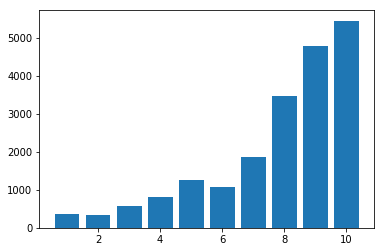

In [190]:
import matplotlib.pyplot as plt

score_stats = {i: 0 for i in range(1, 11)}
for score in scores:
    score_stats[score] += 1

plt.bar(score_stats.keys(), score_stats.values())
plt.show()

In [188]:
samples = {}
for line, score in text_corpus[:5000]:
    samples[score] = line
    
for i in range(1, 11):
    print("Score {}. Text: {}".format(i, samples[i]))

Score 1. Text: В литературном отношении - ниже плинтуса, но почитать имеет смысл, чтобы понять, как устроены мелкие пакостники.
Score 2. Text: Абсолютно согласна с nassy. Автор, ты кто? С чего ты взял, что можешь считать свои банальности истиной? желание возвыситься путем принижения остальных?? так это иллюзия высоты, не более того. Ощущение такое, что книгу "истина в тезисах" написал другой Мороз, а не тот, кто написал "Пособие для гениев". Короче, дрянь книга. А вот "Пособие для гениев" - рекомендую
Score 3. Text: Хрень полная! Похоже на переложенный на бумагу квест. Ходят, ищут, каакие-то подсказки неимоверные. Короче, поддерживаю amam - УЖОС!
Score 4. Text: Довольно бесхребетно и постыло. Однако, некоторые мометы попросту гениальны. Например, сцена с коммивояжером из самого начала.
Score 5. Text: Всё бы, может, и ничего, но эти слёзы-надрывы, надрывы-слёзы... На грани психического срыва, чесслово. И как-то слишком растянуто. Моя психика страдала :)
Score 6. Text: Смотрите, сейчас я

In [136]:
unigramms = {}
bigramms = {}
threegramms = {}

def filter_words(words):
    return list(filter(lambda x: x in special or x[0] in 'абвгдеёжзийклмнопрстуфхцчшщ' \
                       and x not in russian_stopwords, words))

def add_to_gramms(storage, key, score):
    storage[key] = storage.get(key, [])
    storage[key].append(score)

for i, (line, score) in enumerate(lemmatized_text_corpus):
    line = filter_words(line)
    for word in line:
        add_to_gramms(unigramms, word, score)
    for word1, word2 in zip(line, line[1:]):
        add_to_gramms(bigramms, (word1, word2), score)
    for word1, word2, word3 in zip(line, line[1:], line[2:]):
        add_to_gramms(threegramms, (word1, word2, word3), score) 

In [194]:
print(len(threegramms))
print(*dict(sorted(threegramms.items(), key=lambda x: len(x[1]), reverse=True)[4:20]), sep='\n')    

609147
('очень', 'понравиться', 'point')
('beg', 'очень', 'понравиться')
('beg', 'отличный', 'книга')
('понравиться', 'point', 'en')
('beg', 'хороший', 'книга')
('т', 'point', 'д')
('point', 'д', 'point')
('beg', 'отличный', 'фильм')
('не', 'понравиться', 'point')
('не', 'point', 'en')
('beg', 'очень', 'интересный')
('point', 'очень', 'понравиться')
('point', 'главный', 'герой')
('рекомендовать', 'point', 'en')
('point', 'не', 'знать')
('beg', 'хороший', 'фильм')


In [138]:
tone_dict = {}

with open('words_all_full_rating.csv', encoding='cp1251', newline='') as csvfile:
    words = csv.reader(csvfile, delimiter=';')
    next(words)
    for row in words:
        mean = float(row[1].replace(',', '.'))
        d    = float(row[2].replace(',', '.'))
        result = int(row[3])
        if result != 0 and d < 0.5 and abs(mean) > 1:
            tone_dict[row[0]] = {'mean' : mean, 'd' : d, 'res' : result}


In [139]:
def filter_n_grams(ngrams):
    filtered_ngrams = {}

    for key in ngrams:
        word_in = key in tone_dict
        for word in key:
            if word in tone_dict:
                word_in = True
        if word_in:
            filtered_ngrams[key] = ngrams[key]
    return filtered_ngrams

filtered_bigrams = filter_n_grams(bigramms)
filtered_threegrams = filter_n_grams(threegramms)
filtered_unigrams = filter_n_grams(unigramms)

print(*map(len, [filtered_unigrams, filtered_bigrams, filtered_threegrams]))

633 22021 46274


In [140]:
print(dict(sorted(filtered_bigrams.items(), key=lambda x: len(x[1]), reverse=True)[6000:6030]).keys())    

dict_keys([('наркота', 'вера'), ('удивление', 'гармонично'), ('гармонично', 'вплетать'), ('почему', 'жестокий'), ('жестокий', 'добрый'), ('добрый', 'система'), ('предательство', 'подлость'), ('любимый', 'даша'), ('приятно', 'несмотря'), ('конец', 'зло'), ('зло', 'автор'), ('правда', 'ляп'), ('ляп', 'вроде'), ('который', 'погребать'), ('погребать', 'миллион'), ('сюжет', 'роскошный'), ('роскошный', 'изложение'), ('захватывать', 'будить'), ('проза', 'добрый'), ('добрый', 'слишком'), ('мужество', 'все-таки'), ('невыносимый', 'чтение'), ('преступление', 'поступок'), ('пелевин', 'захватывать'), ('захватывать', 'поглощать'), ('нестареющий', 'бессмертный'), ('бессмертный', 'произведение'), ('глупо', 'претензия'), ('excl', 'стыдно'), ('стыдно', 'осознавать')])


In [141]:
filtered_threegrams = {}

for key in threegramms:
    word_in = False
    for word in key:
        if word in tone_dict:
            word_in = True
    if word_in:
        filtered_threegrams[key] = threegramms[key]

print(len(filtered_threegrams))

46274


In [142]:
print(dict(sorted(filtered_threegrams.items(), key=lambda x: len(x[1]), reverse=True)[14000:14030]).keys())    

dict_keys([('считать', 'самый', 'любимый'), ('немного', 'грустный', 'впечатлять'), ('грустный', 'впечатлять', 'point'), ('потрясать', 'книга', 'захватывать'), ('книга', 'захватывать', 'волнительный'), ('захватывать', 'волнительный', 'point'), ('особенно', 'не', 'заморачиваться'), ('не', 'заморачиваться', 'несоответствие'), ('заморачиваться', 'несоответствие', 'современный'), ('интересный', 'очень', 'добрый'), ('снова', 'снова', 'удовольствие'), ('снова', 'удовольствие', 'point'), ('удовольствие', 'point', 'обеспечивать'), ('beg', 'захватывать', 'книга'), ('захватывать', 'книга', 'дочитывать'), ('узнавать', 'интересный', 'момент'), ('интересный', 'момент', 'мелочь'), ('beg', 'очень', 'жестокий'), ('защищать', 'myst', 'плохой'), ('вовсе', 'не', 'надежда'), ('не', 'надежда', 'написать'), ('надежда', 'написать', 'средний'), ('некий', 'ментальный', 'бомба'), ('ментальный', 'бомба', 'point'), ('бомба', 'point', 'любой'), ('разварачиваться', 'настоящий', 'трагедия'), ('настоящий', 'трагедия',

In [143]:
print(dict(filter(lambda x: x[1]['d'] > 1, sorted(tone_dict.items(), key=lambda x: x[1]['res']))), sep='\n')

{}


In [16]:
with open('dataset.txt', 'r') as file:
    with open('answer.txt', 'w') as out:
        for line in file:
            line = filter_words(m.lemmatize(line))
            tones = []
            for prev, word in zip([None] + line, line):
                if word not in tone_dict:
                    continue
                if prev == 'не':
                    tones.append(-tone_dict[word]['mean'])
                else:
                    tones.append(tone_dict[word]['mean'])
            result = sum(tones) / len(tones) * 5 + 5  if tones else 7
            result = max(min(10, int(result)), 1)
            out.write("{}\n".format(result))


In [17]:
with open('dataset.txt', 'r') as file:
    with open('answer.txt', 'w') as out:
        for line in file:
            line = filter_words(m.lemmatize(line))
            tones = []
            for trio in zip(line, line[1:], line[2:]):
                if trio not in filtered_threegrams:
                    continue
                tones.append(sum(filtered_threegrams[trio]) / len(filtered_threegrams[trio]))
            if (tones):
                result = (sum(tones) / len(tones)) if tones else 5
                result = max(min(10, round(result)), 1)
                out.write("{}\n".format(result))
                continue
            for duo in zip(line, line[1:]):
                if duo not in filtered_bigrams:
                    continue
                tones.append(sum(filtered_bigrams[duo]) / len(filtered_bigrams[duo]))
            if tones:
                result = (sum(tones) / len(tones)) if tones else 5
                result = max(min(10, round(result)), 1)
                out.write("{}\n".format(result))
                continue
            for word in line:
                if (word in unigramms):
                    tones.append(sum(unigramms[word]) / len(unigramms[word]))

            result = (sum(tones) / len(tones)) if tones else 7
            result = max(min(10, round(result)), 1)
            out.write("{}\n".format(result))


In [163]:
corpus = []
for line, _ in lemmatized_text_corpus:
    line = filter_words(line)
    res = []
    for prev, word in zip([None] + line, line):
        if word == 'не':
            continue
        if prev == 'не':
            res.append("NOT_" + word)
        else:
            res.append(word)
    corpus.append(' '.join(res))
split_point = 19800
    
train, train_scores = corpus[:split_point], scores[:split_point]
test, test_scores = corpus[split_point:], scores[split_point:]

In [197]:
vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 2))
X = vectorizer.fit_transform(train)

In [198]:
features = vectorizer.get_feature_names()
print(X.shape, vectorizer.get_feature_names()[:10])

(19800, 23933) ['beg', 'beg en', 'beg excl', 'beg haps', 'beg myst', 'beg not_бывать', 'beg not_видеть', 'beg not_впечатлить', 'beg not_говорить', 'beg not_детектив']


In [147]:
regr = RandomForestRegressor(max_depth=10, n_estimators=1000)
regr.fit(X, train_scores)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [181]:
clf = Lasso(max_iter=100000, alpha=0.00001)
clf.fit(X, train_scores)

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [167]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

KeyboardInterrupt: 

In [ ]:
test_X = vectorizer.transform(test)
regr.score(test_X, test_scores)

In [152]:
regr.score(X, train_scores)

0.23124678973668666

In [182]:
with open('dataset.txt', 'r') as file:
    with open('answer.txt', 'w') as out:
        qs = []
        for line in file:
            line = filter_words(['beg'] + map_punct(m.lemmatize(line)) + ['en'])
            res = []
            for prev, word in zip([None] + line, line):
                if word == 'не':
                    continue
                if prev == 'не':
                    res.append("NOT_" + word)
                else:
                    res.append(word)
            qs.append(' '.join(res))
        q_X = vectorizer.transform(qs)
        ys = clf.predict(q_X)
        
        for y in ys:
            result = round(y / 10 * 12 - 1)
            result = max(min(10, int(result)), 1)
            out.write("{}\n".format(result))